In [33]:
from functools import partial
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import scipy.io
import itertools
from skimage import io, filters, morphology, restoration, feature, transform
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import cycle
import sklearn.cluster
from sklearn.preprocessing import MinMaxScaler
import skimage.segmentation as seg
from skimage.future import graph
import skimage.color

import flatpy
import numpy as np

import nglpy as ngl
import topopy
import pdir
import time
import os
import utpy.utils
import utpy.vis

from ipywidgets import interact, widgets

# Upsampled Flow Velocity Example

In [2]:
filename = "upSampled"
n_clusters = 36
my_dir = "output/{}".format(filename)
ensemble = utpy.utils.load_ensemble(filename)

In [3]:
survival_counts = np.zeros(ensemble.shape)
weighted_survival_counts = np.zeros(ensemble.shape)
weighted_instability_counts = np.zeros(ensemble.shape)
weighted_consumption_counts = np.zeros(ensemble.shape)
for i in range(ensemble.shape[2]):
    survival_counts[:, :, i], weighted_survival_counts[:, :, i], weighted_instability_counts[:, :, i], weighted_consumption_counts[:, :, i] = utpy.utils.count_persistence(ensemble[:, :, i])
    
sc_sum = np.sum(survival_counts, axis=2)
sc_med = np.sum(survival_counts, axis=2)

wsc_sum = np.sum(weighted_survival_counts, axis=2)
wsc_med = np.median(weighted_survival_counts, axis=2)

wic_sum = np.sum(weighted_instability_counts, axis=2)
wic_med = np.median(weighted_instability_counts, axis=2)

wcc_sum = np.sum(weighted_consumption_counts, axis=2)
wcc_med = np.median(weighted_consumption_counts, axis=2)

mean_realization = np.mean(ensemble, axis=2)
median_realization = np.median(ensemble, axis=2)

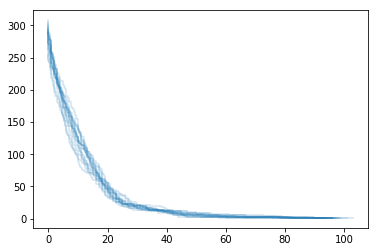

In [4]:
# all_ps, all_counts = utpy.vis.show_persistence_charts(ensemble, my_dir, True)

In [5]:
# persistence = utpy.utils.get_persistence_from_count(ensemble, n_clusters)

In [5]:
@interact(t=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1, continuous_update=False),
          r=widgets.IntSlider(min=1, max=5, step=1, value=1, continuous_update=False))
def visualize(t=0.5, r=1):
    variance_image = threshold_variance(t, r)
    plt.figure(dpi=200)
    log_normalization =  colors.LogNorm(vmin=variance_image.min(), vmax=variance_image.max())
    img = plt.imshow(variance_image, cmap=plt.cm.Greys, vmin=0, vmax=255)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.colorbar(img, orientation="horizontal")
    plt.gca().set_title("Variance r={} | Threshold=10^{}".format(r, t))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_ylim(0, variance_image.shape[0])
    plt.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='t', max=3.0, min=-3.0), Int…

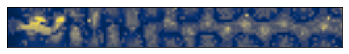

In [6]:
@interact(n_segments=widgets.IntSlider(min=50, max=500, step=1, value=200, continuous_update=False),
#           t=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1, continuous_update=False),
#           r=widgets.IntSlider(min=1, max=5, step=1, value=1, continuous_update=False),
          compactness=widgets.IntSlider(min=-5, max=5, step=1, value=1, continuous_update=False),
          max_iter=widgets.IntSlider(min=10, max=1000, step=10, value=100, continuous_update=False),
          sigma=widgets.IntSlider(min=0, max=3, step=1, value=0, continuous_update=False),
          rag_threshold=widgets.IntSlider(min=0, max=255, step=1, value=50, continuous_update=False),)
def overlay_segmentation(n_segments,
#                          t,
#                          r,
                         compactness,
                         sigma,
                         max_iter,
                         rag_threshold):
    start = time.time()
    normed_wcc_sum = 255*(wcc_sum - np.min(wcc_sum)) / (np.max(wcc_sum) - np.min(wcc_sum))
    image_slic = seg.slic(normed_wcc_sum, n_segments=n_segments, compactness=10**compactness, max_iter=max_iter, sigma=sigma)
#     image_slic = seg.felzenszwalb(image, scale=scale)

    out1 = skimage.color.label2rgb(image_slic, normed_wcc_sum, kind='avg')

    g = graph.rag_mean_color(normed_wcc_sum, image_slic)
    labels2 = graph.cut_threshold(image_slic, g, rag_threshold)
    out2 = skimage.color.label2rgb(labels2, normed_wcc_sum, kind='avg')
    segmentation = out2

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]

    ccycle = cycle(colorList)

    uniqueCount = len(np.unique(segmentation))
    usedColors = []
    for i, c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([k for k in np.unique(segmentation)]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)

    plt.figure(dpi=150)
    img = plt.imshow(wcc_sum, cmap=plt.cm.viridis, interpolation="nearest", origin="lower")
#     img = plt.imshow(image_slic, cmap=cmap, interpolation="nearest", origin="lower")
#     variance_image = threshold_variance(t, r)
#     plt.imshow(variance_image, cmap=plt.cm.Greys, vmin=0, vmax=255)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
#     plt.colorbar(img, ticks=[range(uniqueCount)], boundaries=bounds, orientation="horizontal")
    show_label_boundaries(segmentation, plt.gca())
    end = time.time()
    plt.gca().set_title("N={}| c={} | sigma={} | threshold={} | t={} s".format(n_segments, compactness, sigma, rag_threshold, end-start))

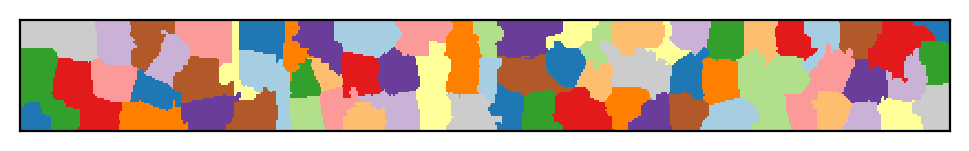

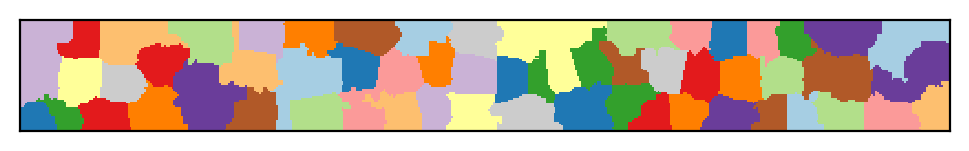

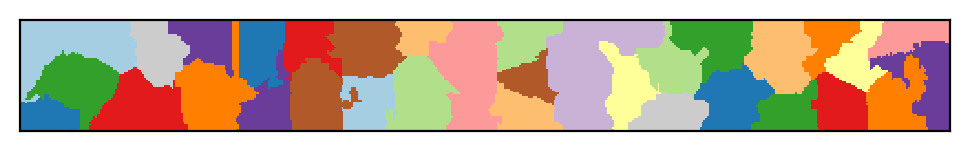

In [7]:
@interact(n_segments=widgets.IntSlider(min=1, max=50, step=1, value=19, continuous_update=False),
          n_partitions=widgets.IntSlider(min=1, max=50, step=1, value=16, continuous_update=False),
          t=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1, continuous_update=False),
          r=widgets.IntSlider(min=1, max=5, step=1, value=1, continuous_update=False))
def overlay_mean(n_segments, n_partitions, t, r):
    image_slic = seg.slic(wcc_sum, n_segments=19)
    labels = get_mc_labels(mean_realization, n_clusters=n_partitions)

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]

    ccycle = cycle(colorList)

    uniqueCount = len(np.unique(labels))
    usedColors = []
    for i, c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([k for k in np.unique(labels)]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)

    plt.figure(dpi=200)
    img = plt.imshow(labels, cmap=cmap, interpolation="nearest", origin="lower")
    plt.contour(wcc_sum, levels=[200, 210], colors="#ffffff")
#     variance_image = threshold_variance(t, r)
#     plt.imshow(variance_image, cmap=plt.cm.Greys, vmin=0, vmax=255)
#     plt.gca().set_xlim(0, variance_image.shape[1])
#     plt.gca().set_ylim(0, variance_image.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
#     plt.colorbar(img, ticks=[range(uniqueCount)], boundaries=bounds, orientation="horizontal")
#     show_label_boundaries(image_slic, plt.gca())

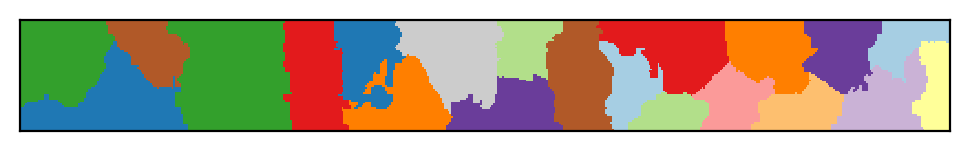

In [36]:
@interact(n_segments=widgets.IntSlider(min=1, max=50, step=1, value=19, continuous_update=False),
          n_partitions=widgets.IntSlider(min=1, max=50, step=1, value=16, continuous_update=False),
          t=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1, continuous_update=False),
          r=widgets.IntSlider(min=1, max=5, step=1, value=1, continuous_update=False))
def overlay_gt(n_segments, n_partitions, t, r):
    image_slic = seg.slic(wcc_sum, n_segments=19)
    labels = get_mc_labels(ground_truth, n_clusters=n_partitions)

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]

    ccycle = cycle(colorList)

    uniqueCount = len(np.unique(labels))
    usedColors = []
    for i, c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([k for k in np.unique(labels)]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)

    plt.figure(dpi=200)
    img = plt.imshow(labels, cmap=cmap, interpolation="nearest", origin="lower")
    plt.contour(wcc_sum, levels=[200, 210], colors="#ffffff")
#     variance_image = threshold_variance(t, r)
#     plt.imshow(variance_image, cmap=plt.cm.Greys, vmin=0, vmax=255)
#     plt.gca().set_xlim(0, variance_image.shape[1])
#     plt.gca().set_ylim(0, variance_image.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
#     plt.colorbar(img, ticks=[range(uniqueCount)], boundaries=bounds, orientation="horizontal")
#     show_label_boundaries(image_slic, plt.gca())

In [64]:
@interact(n_segments=widgets.IntSlider(min=1, max=50, step=1, value=1, continuous_update=False),
          n_partitions=widgets.IntSlider(min=1, max=50, step=1, value=1, continuous_update=False),
          t=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1, continuous_update=False),
          r=widgets.IntSlider(min=1, max=5, step=1, value=1, continuous_update=False),
          gamma=widgets.FloatSlider(min=0.1, max=3, step=0.1, value=2.2, continuous_update=False),)
def overlay_uncertain(n_segments, n_partitions, t, r, gamma):
    image_slic = seg.slic(wcc_sum, n_segments=n_segments)

    plt.figure(dpi=200)
    show_combined_overlay(ensemble, assignments, gamma=gamma, contours=True)
#     img = plt.imshow(image_slic, cmap=cmap, interpolation="nearest", origin="lower")
#     variance_image = threshold_variance(t=0.5, r=1)
#     plt.imshow(variance_image, cmap=plt.cm.Greys, vmin=0, vmax=255)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    show_msc_boundaries(ground_truth, n_clusters=n_clusters, color="#000000")
    show_msc_boundaries(mean_realization, n_clusters=n_clusters, color="#999999")
#     plt.contour(wcc_sum, levels=[200, 210], colors="#ffffff")
#     plt.colorbar(img, ticks=[range(uniqueCount)], boundaries=bounds, orientation="horizontal")
    show_label_boundaries(image_slic, plt.gca())

interactive(children=(IntSlider(value=1, continuous_update=False, description='n_segments', max=50, min=1), In…

# Ackley Non-Parametric Case

In [ ]:
import utpy.utils
import utpy.vis
import flatpy
from functools import partial
from itertools import cycle

In [ ]:
foo = flatpy.nD.available_functions["ackley"]
fractional_noise_level=0.6
persistence = 0.665
n_clusters = 9
count = 50
noise_level = 0.5*persistence*fractional_noise_level
noise_model = "uniform"
ground_truth, ensemble = utpy.utils.generate_ensemble(foo, noise_level, count, noise_model)
ensemble = -ensemble
ground_truth = -ground_truth

graph_params = {
    "index": None, "max_neighbors": 10, "relaxed": False, "beta": 1, "p": 2.
}
maxima_map = utpy.utils.create_assignment_map(ensemble, n_clusters=n_clusters, persistence=persistence)

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/scikit_learn-0.20.0-py3.6-linux-x86_64.egg/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
mandatory_maxima = scipy.io.loadmat("data/upSampled/flowMandatoryMaxima.matlab")['mandatoryMax']
filename = "upSampled"
n_clusters = len(np.unique(mandatory_maxima))-1
my_dir = "output/{}".format(filename)
ensemble = utpy.utils.load_ensemble(filename)

def find_closest_index(points, x):
    x = np.array(x)
    return np.argmin(np.linalg.norm(points - x, axis=1))
mandatory_maxima = scipy.io.loadmat("data/upSampled/flowMandatoryMaxima.matlab")['mandatoryMax']
max_points = list()
max_counts = []
for i in range(ensemble.shape[2]):
    graph = ngl.EmptyRegionGraph(**utpy.utils.graph_params)
    tmc = topopy.MorseComplex(graph=graph,
                                gradient='steepest',
                                normalization=None)

    X, Y = utpy.utils.massage_data(ensemble[:, :, i])
    tmc.build(X, Y)
    for p in tmc.persistences:
        if len(tmc.get_partitions(p).keys()) <= n_clusters:
            for key in tmc.get_partitions(p).keys():
                max_points.append((int(X[key, 0]), int(X[key, 1])))
            break

points = []
labels = []
for row in range(mandatory_maxima.shape[0]):
    for col in range(mandatory_maxima.shape[1]):
        if mandatory_maxima[row, col] != -1:
            points.append((col, row))
            labels.append(mandatory_maxima[row, col])
points = np.array(points)

maxima_map = {}
for i in range(len(max_points)):
    maxima_map[max_points[i]] = labels[find_closest_index(points, max_points[i])]


In [6]:
mean_realization = np.mean(ensemble, axis=2)
median_realization = np.median(ensemble, axis=2)

In [ ]:
def show_msc(grid, persistence=None, n_clusters=None, color="#000000"):
    X, Y = utpy.utils.massage_data(grid)
    h, w = grid.shape

    graph = ngl.EmptyRegionGraph(**utpy.utils.graph_params)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization=None)
    tmc.build(X, Y)

    if persistence is None:
        for p in tmc.persistences:
            if len(tmc.get_partitions(p).keys()) <= n_clusters:
                persistence = p
                break

    partitions = tmc.get_partitions(persistence)
    keys = partitions.keys()

    keyMap = {}
    levels = []
    for i, k in enumerate(keys):
        keyMap[k] = i
        levels.append(i+0.5)

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]

    ccycle = cycle(colorList)

    uniqueCount = len(keys)
    usedColors = []
    for i, c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([keyMap[k] for k in keys]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)

    color_mesh = np.zeros((h, w))
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // w, idx % w] = keyMap[key]

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    for i in keyMap.values():
        lines = plt.contour(color_mesh == i, colors=color, levels=levels, linewidths=1)
    plt.gca().set_aspect("equal")
    return lines

In [ ]:
def show_contour_overlay(ensemble, assignments):
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count

    for i, color in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(*[hex(c).split('x')[-1] for c in color])
        plt.contourf(colored_images[i][:, :, 3], levels=[0.99999, 1], colors=my_color, alpha=0.5)
#         if colored:
#             plt.contourf(colored_images[i][:, :, 3], levels=[
#                          1e-6, 1], colors=my_color, alpha=0.5)
#         else:
#             plt.contourf(colored_images[i][:, :, 3], levels=[
#                          0.99999, 1], colors=my_color, alpha=0.5)
        plt.contour(colored_images[i][:, :, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[
                    1, 0.5, 1.0], linestyles=['solid', 'dashed', 'solid'])
    plt.gca().set_xlim(0, ensemble.shape[1])
    # plt.gca().set_ylim(ensemble.shape[0], 0)
    plt.gca().set_ylim(0, ensemble.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_aspect('equal')

In [ ]:
persistence = utpy.utils.get_persistence_from_count(ensemble, n_clusters)
assignments = partial(utpy.utils.assign_labels, maxima_map=maxima_map, n_clusters=n_clusters, persistence=persistence)

In [10]:
def show_combined_overlay(ensemble, assignments, gamma=2.2, color="#000000"):
    fig, ax = plt.subplots(3, 1, figsize=(4, 12), dpi=200)
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    certain_mask = np.zeros(label_images[0].shape, dtype=bool)
    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count
        certain_mask = np.logical_or(certain_mask, label_image / count == 1)

    composite_image = 255*np.ones(colored_images[0].shape)[:, :, :-1]
    for colored_image in colored_images:
        composite_image = utpy.vis.overlay_alpha_image_precise(
            composite_image, 255*colored_image, 1., gamma)
    for i, triplet in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(*[hex(c).split('x')[-1] for c in triplet])
        ax[1].contourf(colored_images[i][:, :, 3], levels=[
                     0.99999, 1], colors="#FFFFFF", alpha=1)
        ax[2].contourf(colored_images[i][:, :, 3], levels=[
                     0.99999, 1], colors="#FFFFFF", alpha=1)
#         ax[1].contourf(colored_images[i][:, :, 3], levels=[0.99999, 1], colors=my_color, alpha=1)
        ax[1].contour(colored_images[i][:, :, 3], levels=[0.5], colors="#000000", linewidths=[1], linestyles=['solid'])
        ax[2].contour(colored_images[i][:, :, 3], levels=[0.5], colors="#000000", linewidths=[1], linestyles=['solid'])

    certain_image = np.copy(composite_image)
    certain_image[~np.dstack((certain_mask,)*3)] = 255
    ax[0].imshow(certain_image)
    ax[1].imshow(composite_image)
    ax[2].imshow(composite_image)
    for a in ax:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        # a.set_ylim(ensemble.shape[0], 0)
        a.set_ylim(0, ensemble.shape[0])
    return certain_image, certain_mask, composite_image

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


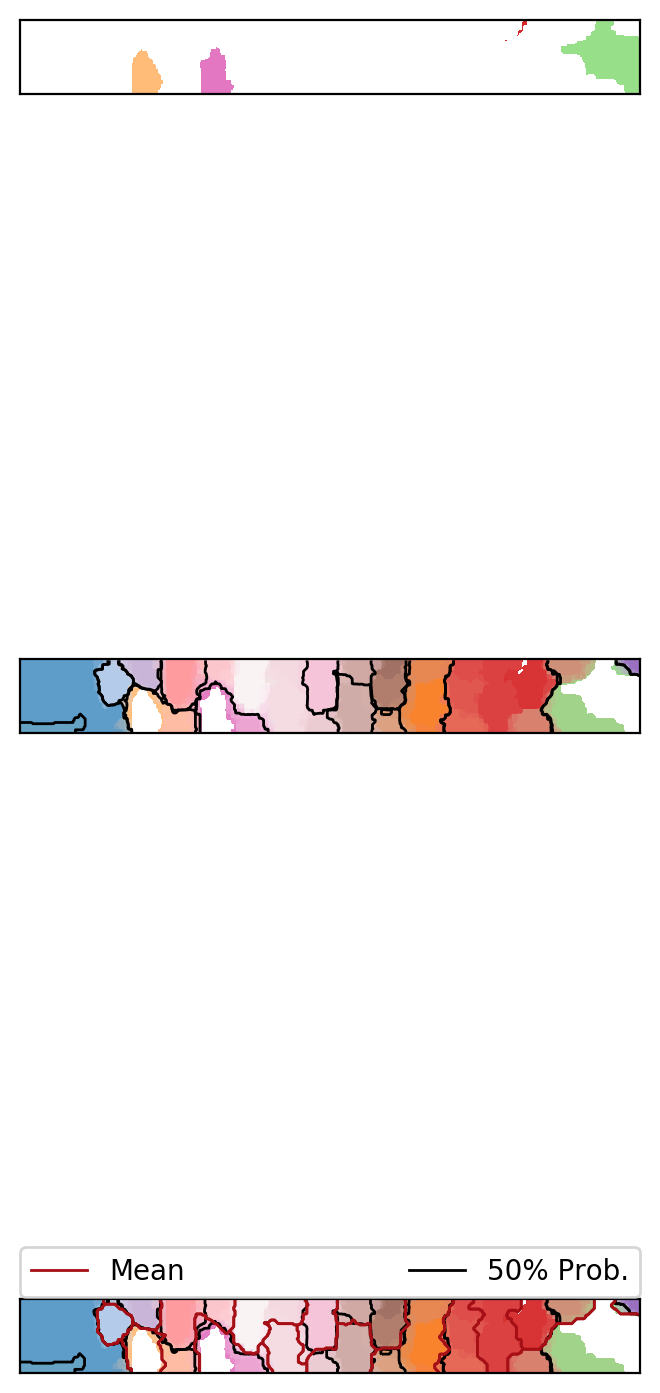

In [11]:
color_list = []
for i in range(20):
    color_list.append([int(255*c) for c in plt.cm.tab20(i)])

ccycle = cycle(color_list)

umc_color = "#000000"
gt_color = "#4daf4a"
mean_color = "#a50f15"
certain_image, certain_mask, composite_image = show_combined_overlay(ensemble, assignments, 1, umc_color)
# show_msc(ground_truth, n_clusters=n_clusters, color=gt_color)
show_msc(mean_realization, n_clusters=n_clusters, color=mean_color)
# plt.plot([-1,-0.5], [0,1], color=gt_color, linewidth=1, label="Truth")
plt.gca().plot([-1,-0.5], [0,1], color=mean_color, linewidth=1, label="Mean")
plt.gca().plot([-1,-0.5], [0,1], color=umc_color, linewidth=1, label="50% Prob.")
plt.gca().set_xlim(0, ensemble.shape[1])
plt.gca().set_ylim(0,ensemble.shape[0])
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)


In [ ]:
def show_certain_regions(ensemble, assignments, contours=False):
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count

    for i, color in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(
            *[hex(c).split('x')[-1] for c in color])
        plt.contourf(colored_images[i][:, :, 3], levels=[
                     0.99999, 1], colors=my_color, alpha=1)
        if contours:
            plt.contour(colored_images[i][:, :, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[
                        1, 0.5, 1.0], linestyles=['solid', 'dashed', 'solid'])
        # else:
        #     plt.contour(colored_images[i][:, :, 3], levels=[0.0, 1], colors=my_color, linewidths=[
        #                 1, 1.0], linestyles=['solid', 'dashed', 'solid'])
    plt.gca().set_xlim(0, ensemble.shape[1])
    # plt.gca().set_ylim(ensemble.shape[0], 0)
    plt.gca().set_ylim(0, ensemble.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_aspect('equal')

In [13]:
color_list = [[141, 211, 199], [255, 255, 179], [190, 186, 218],
              [251, 128, 114], [128, 177, 211], [253, 180, 98],
              [179, 222, 105], [252, 205, 229], [217, 217, 217]]
# color_list = [[228,26,28], [55,126,184], [77,175,74],
#               [152,78,163],[255,127,0],[255,255,51],
#               [166,86,40],[247,129,191],[153,153,153]]
# color_list = [[105,239,123], [149,56,144], [66,30,200],
#                 [14,80,62], [153,222,249], [24,81,155],
#                 [218,185,255], [192,222,164], [183,211,33]]
# color_list = [[251,180,174],[179,205,227],[204,235,197],
#               [222,203,228],[254,217,166],[255,255,204],
#               [229,216,189],[253,218,236],[242,242,242]]



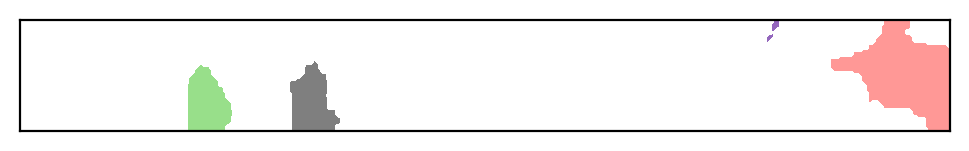

In [14]:
plt.figure(dpi=200)
show_certain_regions(ensemble, assignments)

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


<Figure size 1200x800 with 0 Axes>

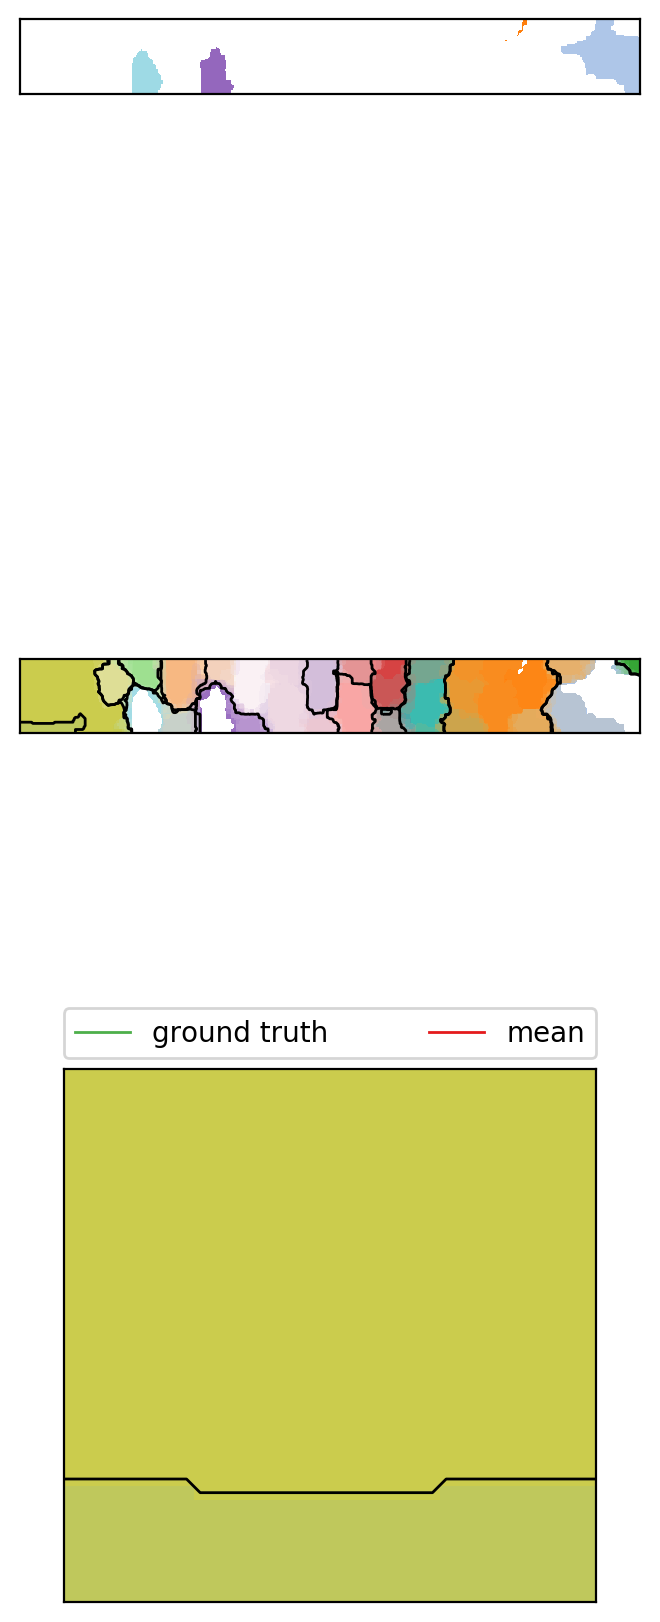

In [15]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 0.6, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


<Figure size 1200x800 with 0 Axes>

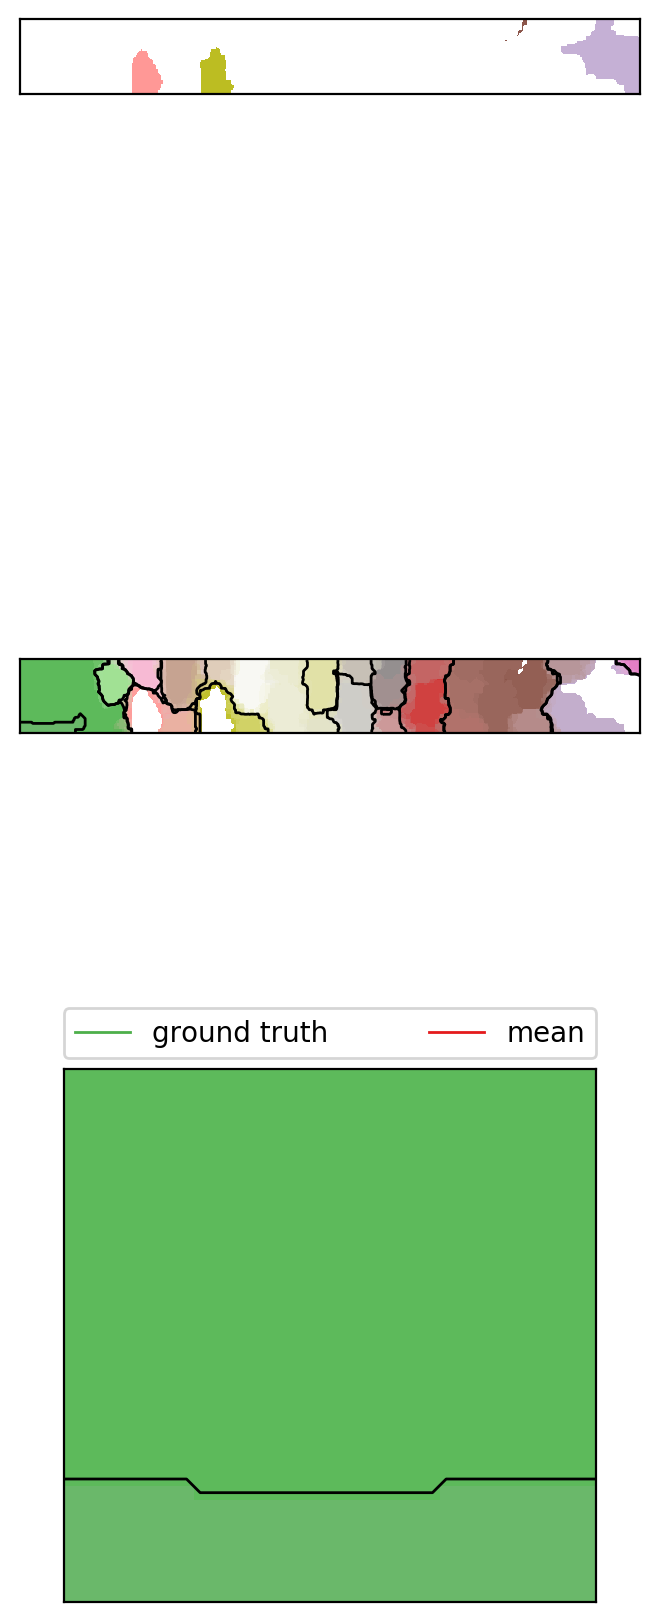

In [16]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 0.8, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


<Figure size 1200x800 with 0 Axes>

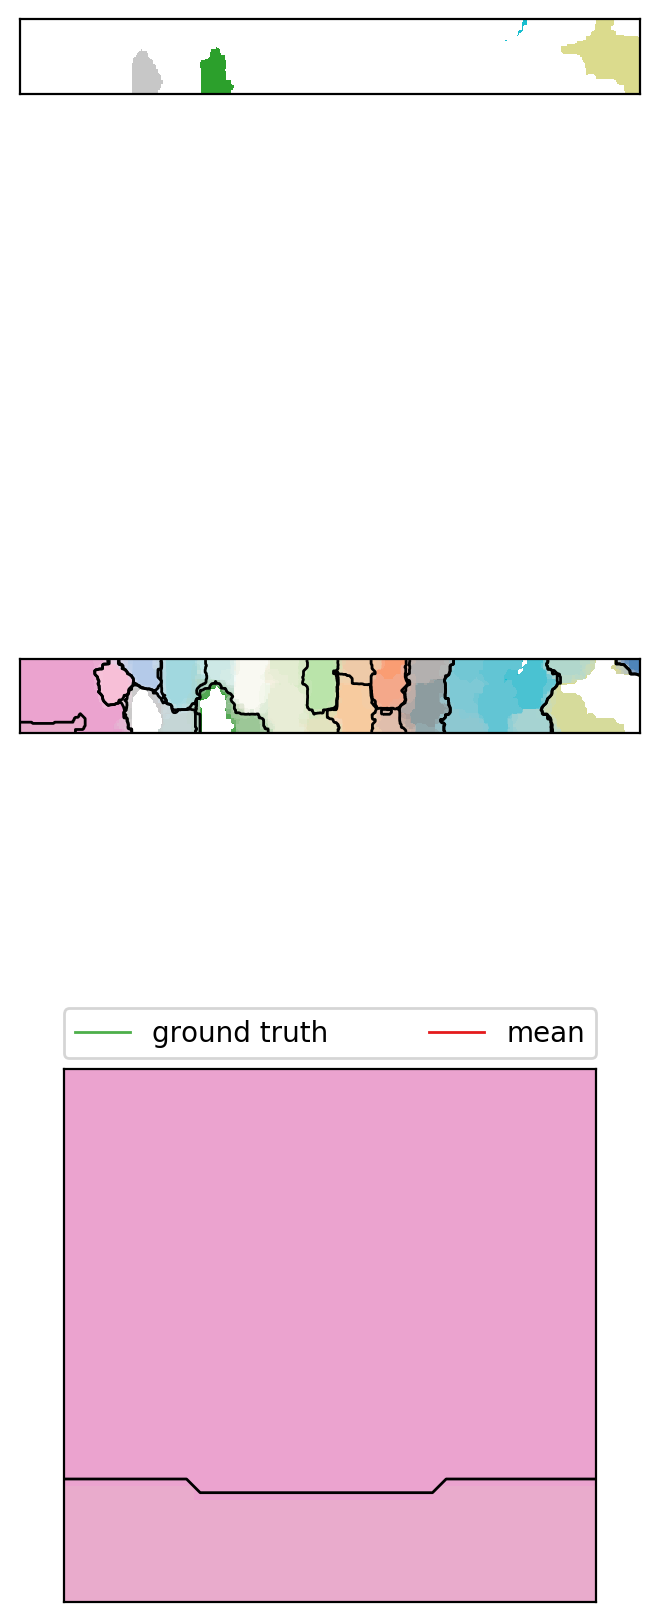

In [17]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 2.2, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

# Flow Analysis

# Persistence Example

In [23]:
import flatpy
from ipywidgets import interact, widgets

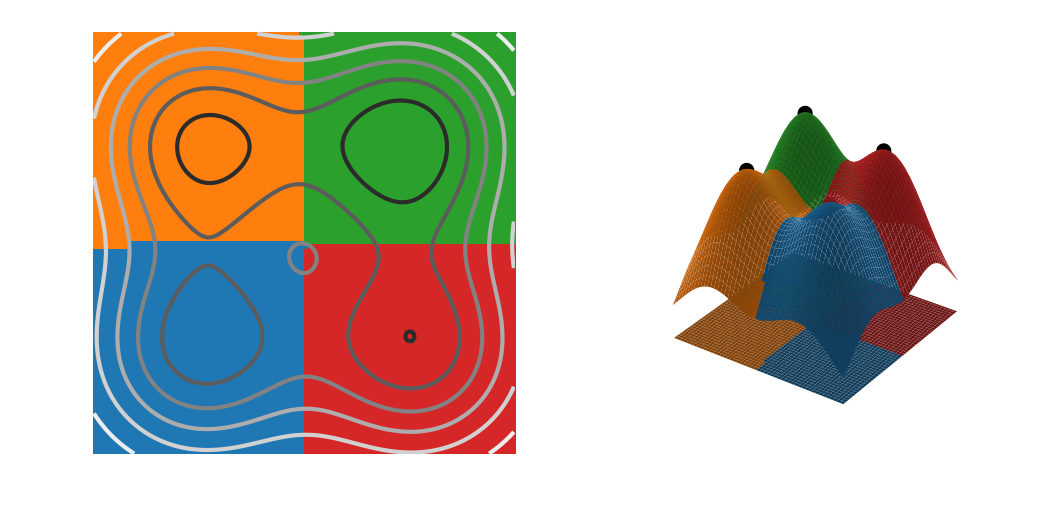

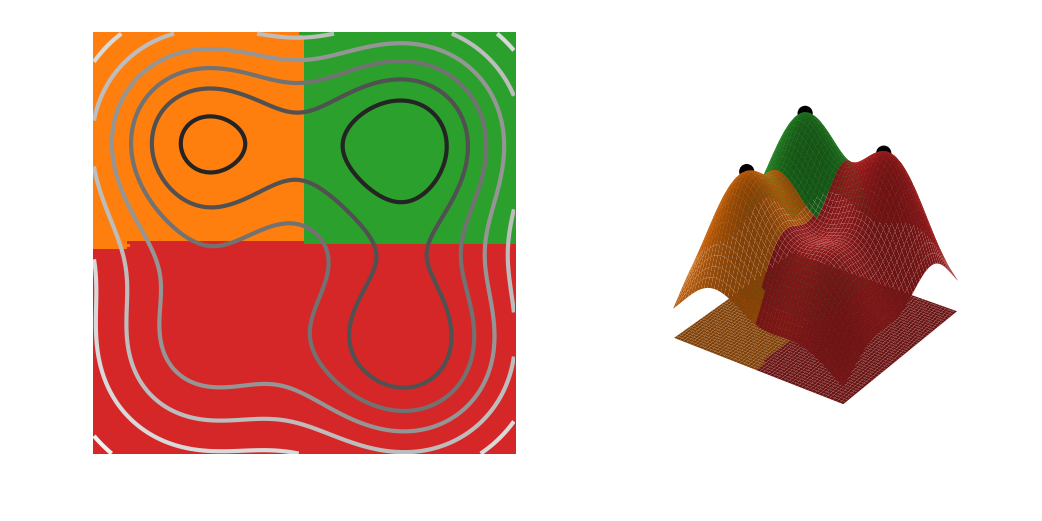

In [136]:
%matplotlib inline

sigma = 0.075
max_x_1 = 0.25
max_y_1 = 0.25
max_x_2 = 0.25
max_y_2 = 0.75
def four_bumps(_x):
    x, y = flatpy.utils.unpack_2d(_x)
    eps = 0.01*y + 0.01*x
    return (0.5 * np.exp(-(((x-max_x_1)**2)/sigma +((y-max_y_1)**2)/sigma)) +
            0.54 * np.exp(-(((x-0.75)**2)/sigma +((y-0.25)**2)/sigma)) +
            0.51 * np.exp(-(((x-max_x_2)**2)/sigma +((y-0.77)**2)/sigma)) +
            0.58 * np.exp(-(((x-0.75)**2)/sigma +((y-0.75)**2)/sigma)) + eps
           )

def three_bumps(_x, t=0.4):
    x, y = flatpy.utils.unpack_2d(_x)
    eps = 0.01*y + 0.01*x
    amplitude = (1-t)*0.54
    x_loc = (1-t)*max_x_1 + t*max_x_2
    return (amplitude * np.exp(-(((x-x_loc)**2)/sigma +((y-max_y_1)**2)/sigma)) +
            0.54 * np.exp(-(((x-0.75)**2)/sigma +((y-0.25)**2)/sigma)) +
            0.51 * np.exp(-(((x-max_x_2)**2)/sigma +((y-max_y_2)**2)/sigma)) +
            0.58 * np.exp(-(((x-0.75)**2)/sigma +((y-0.75)**2)/sigma)) + eps
           )

resolution=150
X = flatpy.utils.generate_test_grid_2d(resolution)
f1 = four_bumps(X)
f2 = three_bumps(X)

x, y = np.mgrid[0:1:(resolution *1j), 0:1:(resolution*1j)]
f1 = f1.reshape(resolution,resolution)
f2 = f2.reshape(resolution,resolution)

graph = ngl.EmptyRegionGraph(**utpy.utils.graph_params)
tmc = topopy.MorseComplex(graph=graph, normalization=None)
tmc.build(X, f1.flatten())

n_clusters = 4
for p in tmc.persistences:
    if len(tmc.get_partitions(p).keys()) <= n_clusters:
        partitions = tmc.get_partitions(p)
        break

keys = list(partitions.keys())
keyMap = {}
for i, k in enumerate(keys):
    keyMap[k] = i

ccycle = cycle(plt.cm.tab10.colors)
uniqueCount = len(keys)
usedColors = []
for i, c in zip(range(uniqueCount), ccycle):
    usedColors.append(c)
cmap = colors.ListedColormap(usedColors)

for f in [f1, f2]:
    for p in tmc.persistences:
        if len(tmc.get_partitions(p).keys()) <= n_clusters:
            partitions = tmc.get_partitions(p)
            break

    color_mesh = np.zeros((resolution, resolution), dtype=int)
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // resolution, idx % resolution] = keyMap[key]
    
    keys = list(partitions.keys())
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(plt.cm.tab10(color_mesh.T))
    ax.set_ylim(0,resolution)
#     ax.set_xlim(resolution,0)
    ax.axis("off")
    plt.contour(f,cmap=plt.cm.Greys)
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    surf = ax.plot_surface(x, y, f, linewidth=0, antialiased=True, facecolors=plt.cm.tab10(color_mesh))
    surf = ax.plot_surface(x, y, np.zeros(x.shape), linewidth=0, antialiased=True, facecolors=plt.cm.tab10(color_mesh))
    ax.scatter(X[keys, 0], X[keys, 1], f.flatten()[keys], s=20, alpha=1, c="#000000",zorder=5)
    # ax.contour(x, y, f, cmap=plt.cm.Greys, linewidths=3, alpha=1)
    ax.view_init(azim=215)
    ax.set_aspect(1)
    ax.axis("off")
    n_clusters -= 1